### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Data loading

In [84]:
# Unzip train_data.npy, test_data.npy, val_data.npy
# !unzip all_data.zip

# Load the data
train_data = np.load('all_data/train_data.npy')
test_data = np.load('all_data/test_data.npy')
val_data = np.load('all_data/val_data.npy')

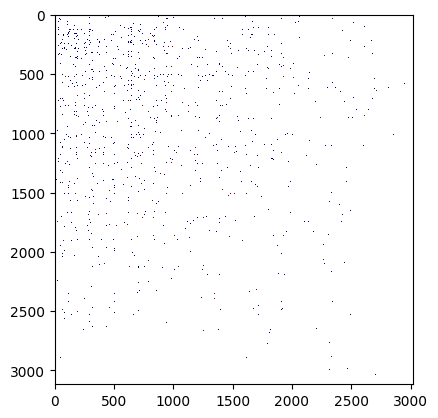

In [85]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

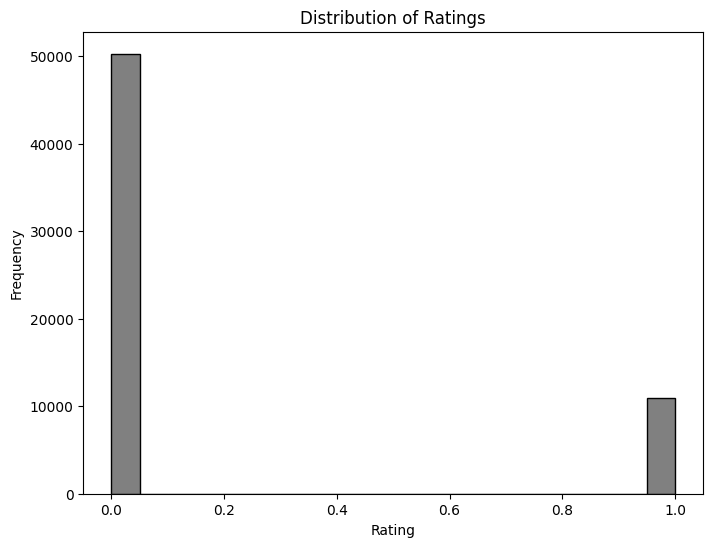

In [86]:
# Further visualizations to justify your answers to the familiarization questions below

ratings = train_data[~np.isnan(train_data)]  # filter out missing entries
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=20, color='grey', edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [87]:
ratings

array([0., 1., 1., ..., 0., 0., 0.])

**Familiarization questions**
1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

* Sparsity: The user-item matrices are sparse, affecting how we handle missing entries and how we design the recommendation algorithm. We might use techniques that works with sparse matrices such as NMF.

* Distribution of ratings: We can choose appropriate loss functions and pre-processing steps accordingly.

* Cold-start problem: Many users start with few or now ratings, requiring techniques to handle the cold-start problem.



2.	What are some sources of sparsity in the data?

* The long tail phenomenon: A small number of items tend to be popular while many items are left with few ratings.

* User behavior: Users often rate only a small number of items.

* Data collection methods: The source of data and the way it is collected. This data might be sampled from a large set of real data and hence the sparsity.


3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

    Yes. We see clusters in the matrix visualization, showing the preference of different groups of users. Also we find the interaction diversity between users, i.e. some are more active in giving ratings while others are not.

## WebLab solutions

In [88]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
  """
  Decomposes the original sparse matrix X into two matrices W and H. 
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  for _ in range (max_iter):
    WH = np.dot(W, H)
    N = np.dot(W.T, X)
    D = np.dot(W.T, WH) + 1e-9
    H *= N / D

    WH = np.dot(W, H)
    N = np.dot(X, H.T)
    D = np.dot(WH, H.T) + 1e-9
    W *= N / D

    error = np.sum((X.to_numpy() - np.dot(W, H)) ** 2)

    if error < tol:
      break

  return W, H

In [89]:
# Solution: Min-hashing routine (for unit test on weblab)
import sys

class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value
    

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """
    
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    
    N = len(space)
    mat = [[id_value in id_ for id_ in ids] for id_value in sorted_space]
    for r in range(len(mat)):
        hash_r = [hashf.hashf(r, N) for hashf in hashes]
        for c in range(len(mat[r])):
            if mat[r][c]:
                for i in range(len(hashes)):
                    result[i][c] = min(result[i][c], hash_r[i])
                
    return result

## NMF-based recommender system

In [90]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    # Solution: NMF routine (for unit test on weblab)

    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    #X = X.to_numpy()
    X = np.ma.masked_where(np.isnan(X), X)

    for _ in range (max_iter):
        WH = np.dot(W, H)
        N = np.ma.dot(W.T, X)
        D = np.dot(W.T, WH) + 1e-9
        H *= N / D

        WH = np.dot(W, H)
        N = np.ma.dot(X, H.T)
        D = np.dot(WH, H.T) + 1e-9
        W *= N / D

        diff = X - np.dot(W, H)
        reconstruction_error = np.ma.sum(diff ** 2)
        
        if reconstruction_error < tol:
            break

    return W, H, reconstruction_error

In [91]:
# step 1.5: mask out some entries to do validation afterwards

def create_train_val_split(data, validation_frac = 0.1):
    np.random.seed(5)

    data = data.copy()
    train_data = data.copy()
    val_data = np.full(data.shape, np.nan)
    
    observed_indices = np.argwhere(~np.isnan(data))
    n_total = observed_indices.shape[0]
    n_val = int(np.floor(n_total * validation_frac))
    perm = np.random.permutation(n_total)
    val_indices = observed_indices[perm[:n_val]]
    
    for i, j in val_indices:
        val_data[i, j] = train_data[i, j]
        train_data[i, j] = np.nan
    
    # Ensure that no row is entirely masked out
    n_rows, n_cols = train_data.shape
    for i in range(n_rows):
        if np.all(np.isnan(train_data[i, :])):
            valid_cols = np.where(~np.isnan(val_data[i, :]))[0]
            if valid_cols.size > 0:
                j = valid_cols[0]
                train_data[i, j] = val_data[i, j]
                val_data[i, j] = np.nan
                
    # Ensure that no column is entirely masked
    for j in range(n_cols):
        if np.all(np.isnan(train_data[:, j])):
            valid_rows = np.where(~np.isnan(val_data[:, j]))[0]
            if valid_rows.size > 0:
                i = valid_rows[0]
                train_data[i, j] = val_data[i, j]
                val_data[i, j] = np.nan
    
    return train_data, val_data

In [92]:
full_train_data = train_data.copy()
train_data, val_data = create_train_val_split(train_data)

N=5, Error=8970.72304269753.
N=10, Error=8636.762416411932.
N=20, Error=8048.121327918018.
N=50, Error=7093.966745201508.
N=100, Error=5983.609023325509.


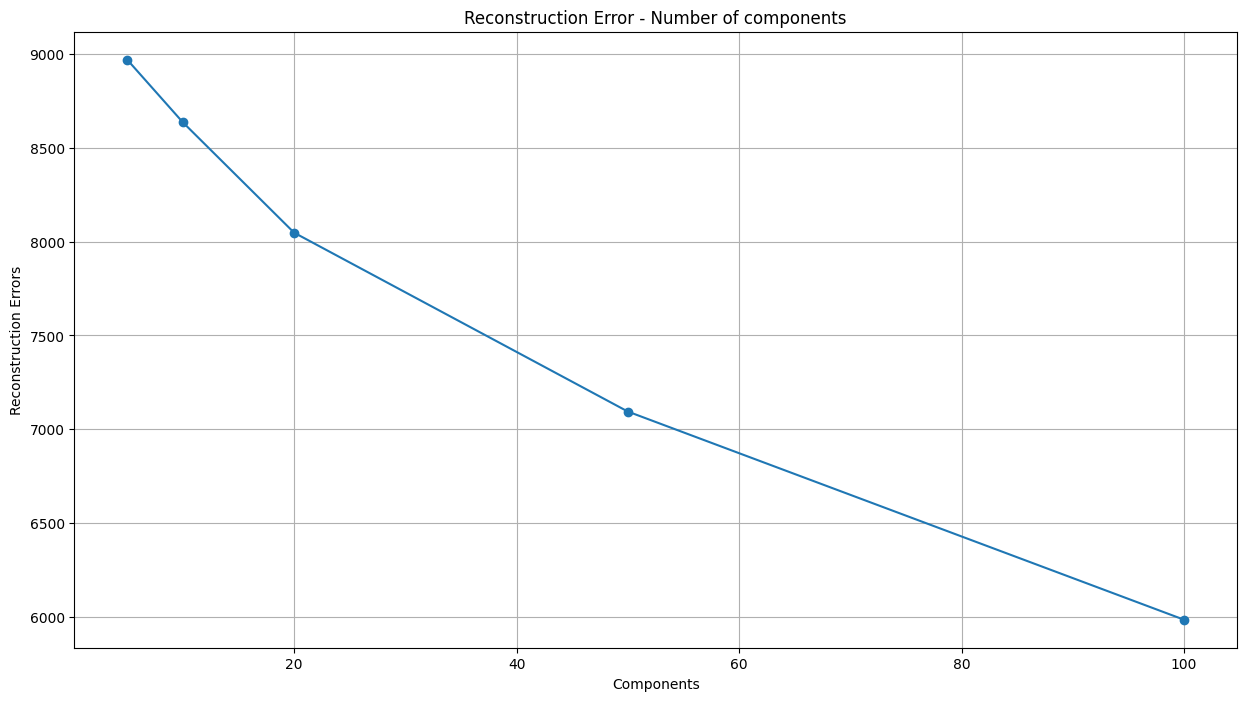

In [93]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.
errors = []

for n in list_components:
    W, H, reconstruction_error = nmf_nan(train_data, n_components=n, max_iter=10)
    errors.append(reconstruction_error)
    print(f"N={n}, Error={reconstruction_error}.")

# Plot the final reconstruction error as a function of n_components
plt.figure(figsize=(15, 8))
plt.plot(list_components, errors, marker='o', linestyle='-')
plt.xlabel("Components")
plt.ylabel("Reconstruction Errors")
plt.title("Reconstruction Error - Number of components")
plt.grid(True)
plt.show()


In [94]:
reconstructed_ratings = np.dot(W, H) # The last result

list_thr = np.array([0.01, 0.05, 0.075, 0.1, 0.12, 0.15, 0.5])

for thr in list_thr:
    print(f'Threshold = {thr}')
    print(np.count_nonzero(reconstructed_ratings < thr))
    print(np.count_nonzero(reconstructed_ratings >= thr))

Threshold = 0.01
9136265
273859
Threshold = 0.05
9339665
70459
Threshold = 0.075
9368709
41415
Threshold = 0.1
9383324
26800
Threshold = 0.12
9390162
19962
Threshold = 0.15
9396134
13990
Threshold = 0.5
9407798
2326


In [95]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...
training_accuracies = {}
observed_mask = ~np.isnan(train_data)
for n in list_components:
    for thr in list_thr:
        # Compute training accuracy
        truth = (train_data[observed_mask] >= thr).astype(int)
        reconstructed = (reconstructed_ratings[observed_mask] >= thr).astype(int)

        accuracy = np.mean(truth == reconstructed)
        #training_accuracies[(n, thr)] = accuracy

        print(f"components: {n}, threshold: {thr:.2f}, training accuracy: {accuracy:.4f}")


components: 5, threshold: 0.01, training accuracy: 0.8250
components: 5, threshold: 0.05, training accuracy: 0.9028
components: 5, threshold: 0.07, training accuracy: 0.9116
components: 5, threshold: 0.10, training accuracy: 0.9117
components: 5, threshold: 0.12, training accuracy: 0.9094
components: 5, threshold: 0.15, training accuracy: 0.9053
components: 5, threshold: 0.50, training accuracy: 0.8607
components: 10, threshold: 0.01, training accuracy: 0.8250
components: 10, threshold: 0.05, training accuracy: 0.9028
components: 10, threshold: 0.07, training accuracy: 0.9116
components: 10, threshold: 0.10, training accuracy: 0.9117
components: 10, threshold: 0.12, training accuracy: 0.9094
components: 10, threshold: 0.15, training accuracy: 0.9053
components: 10, threshold: 0.50, training accuracy: 0.8607
components: 20, threshold: 0.01, training accuracy: 0.8250
components: 20, threshold: 0.05, training accuracy: 0.9028
components: 20, threshold: 0.07, training accuracy: 0.9116
comp

In [96]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

validation_accuracies = {}
observed_mask = ~np.isnan(val_data)
for n in list_components:
    for thr in list_thr:
        # Compute training accuracy
        truth = (val_data[observed_mask] >= thr).astype(int)
        reconstructed = (reconstructed_ratings[observed_mask] >= thr).astype(int)

        accuracy = np.mean(truth == reconstructed)
        #validation_accuracies[(n, thr)] = accuracy

        print(f"components: {n}, threshold: {thr:.2f}, validation accuracy: {accuracy:.4f}")


components: 5, threshold: 0.01, validation accuracy: 0.7743
components: 5, threshold: 0.05, validation accuracy: 0.8235
components: 5, threshold: 0.07, validation accuracy: 0.8281
components: 5, threshold: 0.10, validation accuracy: 0.8298
components: 5, threshold: 0.12, validation accuracy: 0.8296
components: 5, threshold: 0.15, validation accuracy: 0.8293
components: 5, threshold: 0.50, validation accuracy: 0.8262
components: 10, threshold: 0.01, validation accuracy: 0.7743
components: 10, threshold: 0.05, validation accuracy: 0.8235
components: 10, threshold: 0.07, validation accuracy: 0.8281
components: 10, threshold: 0.10, validation accuracy: 0.8298
components: 10, threshold: 0.12, validation accuracy: 0.8296
components: 10, threshold: 0.15, validation accuracy: 0.8293
components: 10, threshold: 0.50, validation accuracy: 0.8262
components: 20, threshold: 0.01, validation accuracy: 0.7743
components: 20, threshold: 0.05, validation accuracy: 0.8235
components: 20, threshold: 0.07

In [97]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

# Compute test accuracy
n_components = 50
threshold = 0.1

observed_mask = ~np.isnan(test_data)
truth = (test_data[observed_mask] >= threshold).astype(int)

W, H, err = nmf_nan(test_data, n_components=n_components, max_iter=10)

predicted = np.dot(W, H)
reconstructed = (predicted[observed_mask] >= threshold).astype(int)

accuracy = np.mean(truth == reconstructed)

print(f"Test accuracy: {accuracy:g}, error = {err}")

Test accuracy: 0.888491, error = 1378.9218669376864


## Distance-based recommender system

In [110]:
# Define helper functions

def jaccard_distance(sig1, sig2):
    return 1 - np.mean(sig1 == sig2)

def get_binary_sets(data, threshold):
    n_users, n_items = data.shape
    user_sets = []
    for i in range(n_users):
        items = set(np.where((~np.isnan(data[i, :])) & (data[i, :] >= threshold))[0])
        user_sets.append(items)
    item_sets = []
    for j in range(n_items):
        users = set(np.where((~np.isnan(data[:, j])) & (data[:, j] >= threshold))[0])
        item_sets.append(users)
    return user_sets, item_sets

def get_nearest_neighbors(signature, num_neighbors):
    num_objects = signature.shape[1]
    neighbors = []
    for i in range(num_objects):
        dists = []
        for j in range(num_objects):
            if i == j:
                continue
            else:
                d = jaccard_distance(signature[:, i], signature[:, j])
                dists.append((j, d))
        dists.sort(key=lambda x: x[1])
        nn = [j for j, _ in dists[:num_neighbors]]
        neighbors.append(nn)
    return neighbors

def aggregate_prediction(user, item, user_neighbors, item_neighbors, rating_matrix, global_mean):
    user_ratings = []
    for nb in user_neighbors:
        r = rating_matrix[nb, item]
        if not np.isnan(r):
            user_ratings.append(r)
    item_ratings = []
    for nb in item_neighbors:
        r = rating_matrix[user, nb]
        if not np.isnan(r):
            item_ratings.append(r)
    preds = []
    if user_ratings:
        preds.append(np.mean(user_ratings))
    if item_ratings:
        preds.append(np.mean(item_ratings))
    if preds:
        return np.mean(preds)
    else:
        return global_mean

def binarize(rating, threshold):
    return int(rating >= threshold)


In [111]:
global_mean = np.nanmean(train_data)
default_threshold = 3.5

list_num_hashes = [5, 10]   # number of hash functions
list_neighbors = [5, 10]     # number of neighbors

# Store best parameters
best_val_accuracy = -1
best_params = None

In [112]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance
user_sets, _ = get_binary_sets(train_data, threshold=default_threshold)

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance 
_, item_sets = get_binary_sets(train_data, threshold=default_threshold)

In [113]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.

for num_hashes in list_num_hashes:
    hash_funcs = [HashFunction(alpha=i+1, beta=i+7) for i in range(num_hashes)]
    
    user_signature = compute_signature(hash_funcs, user_sets)
    item_signature = compute_signature(hash_funcs, item_sets)
    
    for k in list_neighbors:
        user_neighbors = get_nearest_neighbors(user_signature, num_neighbors=k)
        item_neighbors = get_nearest_neighbors(item_signature, num_neighbors=k)
        
        val_indices = np.argwhere(~np.isnan(val_data))
        correct = 0
        total = 0
        for i, j in val_indices:
            pred = aggregate_prediction(i, j, user_neighbors[i], item_neighbors[j],
                                          train_data, global_mean)
            pred_bin = binarize(pred, default_threshold)
            true_bin = binarize(val_data[i, j], default_threshold)
            if pred_bin == true_bin:
                correct += 1
            total += 1
        val_accuracy = correct / total if total > 0 else 0
        print(f"num_hashes={num_hashes}, neighbors={k}, Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = (num_hashes, k, default_threshold)

num_hashes=10, neighbors=5, Validation Accuracy: 1.0000


In [ ]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations

best_num_hashes, best_neighbors, best_threshold = best_params
print("\nBest parameters on validation set:")
print(f"Number of hash functions: {best_num_hashes}, Neighbors: {best_neighbors}, Threshold: {best_threshold}")
    
# Recompute binary sets on full training data (using best_threshold).
user_sets_full, item_sets_full = get_binary_sets(full_train_data, threshold=best_threshold)
# Create hash functions with best_num_hashes.
best_hash_funcs = [HashFunction(alpha=i+1, beta=(i+7)) for i in range(best_num_hashes)]
user_signature_full = compute_signature(best_hash_funcs, user_sets_full)
item_signature_full = compute_signature(best_hash_funcs, item_sets_full)
user_neighbors_full = get_nearest_neighbors(user_signature_full, best_neighbors)
item_neighbors_full = get_nearest_neighbors(item_signature_full, best_neighbors)
global_mean_full = np.nanmean(full_train_data)


Best parameters on validation set:
Number of hash functions: 10, Neighbors: 5, Threshold: 3.5


In [115]:
# Report recommendation accuracy on the independent test data

test_indices = np.argwhere(~np.isnan(test_data))
correct_test = 0
total_test = 0
for i, j in test_indices:
    pred = aggregate_prediction(i, j, user_neighbors_full[i], item_neighbors_full[j],
                                full_train_data, global_mean_full)
    pred_bin = binarize(pred, best_threshold)
    true_bin = binarize(test_data[i, j], best_threshold)
    if pred_bin == true_bin:
        correct_test += 1
    total_test += 1
test_accuracy = correct_test / total_test if total_test > 0 else 0
print(f"\nTest Accuracy: {test_accuracy}")


Test Accuracy: 1.0000
